In [1]:
install.packages("tidyr")

also installing the dependencies ‘generics’, ‘R6’, ‘stringi’, ‘pkgconfig’, ‘withr’, ‘dplyr’, ‘magrittr’, ‘purrr’, ‘stringr’, ‘tibble’, ‘tidyselect’, ‘cpp11’





The downloaded binary packages are in
	/var/folders/82/m_lbk9dx643cmp13387_7kzc0000gn/T//RtmpfCFNEz/downloaded_packages


In [3]:
install.packages("dplyr") 


The downloaded binary packages are in
	/var/folders/82/m_lbk9dx643cmp13387_7kzc0000gn/T//RtmpfCFNEz/downloaded_packages


In [45]:
# installed.packages()

In [7]:
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [9]:
library(tidyr)

In [15]:
# --- setup --------------------------------------------------------------------
set.seed(42)
suppressPackageStartupMessages({
  library(dplyr)
  library(tidyr)
})

# --- study parameters ---------------------------------------------------------
study_id <- "MIG666"
countries <- c("Cambodia", "Brazil", "Colombia", "Curacao",
               "Thailand", "Poland", "Portugal", "United States")
sites_per_country <- c(Cambodia=2, Brazil=3, Colombia=2, Curacao=1,
                       Thailand=2, Poland=2, Portugal=2, "United States"=4)

# --- site generation (unique IDs, no duplicates) ------------------------------
site_start_id <- 666
n_sites <- sum(sites_per_country)

site_df <- tibble(
  SITEID  = as.character(seq(site_start_id, length.out = n_sites)),
  COUNTRY = rep(names(sites_per_country), times = sites_per_country)
)

# --- trial summary (TS) -------------------------------------------------------
ts_df <- tibble(
  STUDYID = study_id,
  DOMAIN  = "TS",
  TSSEQ   = 1:6,
  TSPARMCD = c("TITLE", "PHASE", "TRT", "PLANSUB", "CNTINV", "COUNTRY"),
  TSPARM   = c("Study Title", "Study Phase", "Investigational Treatment",
               "Planned Number of Subjects", "Planned Number of Sites",
               "Participating Countries"),
  TSVAL    = c("A Phase 1 Randomized Study of a Migraine Slaying Chewing Gum",
               "Phase 1", "Gum MIG666", "50",
               nrow(site_df),
               paste(countries, collapse = ", "))
)

# --- arms and elements --------------------------------------------------------
arms <- tibble(
  ARMCD = c("PLACEBO", "MIGL", "MIGM", "MIGH"),
  ARM   = c("Placebo", "Low Dose Gum", "Medium Dose Gum", "High Dose Gum")
)

trial_elements <- tibble(
  ETCD  = c("SCREENING", "TREATMENT", "FOLLOWUP"),
  EPOCH = c("Screening", "Treatment", "Follow-up")
)

# TA: arms × elements
ta_df <- arms %>%
  tidyr::crossing(trial_elements) %>%
  group_by(ARMCD) %>%
  mutate(
    STUDYID = study_id,
    DOMAIN  = "TA",
    TAETORD = row_number()
  ) %>%
  ungroup()

# TE
te_df <- tibble(
  STUDYID = study_id,
  DOMAIN  = "TE",
  ETCD    = c("SCREENING", "TREATMENT", "FOLLOWUP"),
  ELEMENT = c("Screening", "Treatment", "Follow-up"),
  TESTRL  = c(0, 1, 15)
)

# TV (visits)
visits <- tibble(
  VISITNUM = 1:10,
  VISIT = c("Screening", "Treatment Visit 1", "Treatment Visit 2", "Treatment Visit 3",
            "Treatment Visit 4", "End of Treatment",
            "Follow-up Visit 1", "Follow-up Visit 2", "Follow-up Visit 3",
            "End of Study"),
  TVSTRL = c(0, 1, 3, 5, 7, 8, 14, 21, 28, 35)
)

tv_df <- visits %>%
  mutate(STUDYID = study_id, DOMAIN = "TV")

# --- DM (subjects) ------------------------------------------------------------
n_subjects <- 50
races <- c("WHITE", "BLACK OR AFRICAN AMERICAN", "ASIAN", "OTHER")

n_arms <- nrow(arms)
base_per_arm <- n_subjects %/% n_arms
remainder <- n_subjects %% n_arms

# Balance subjects across arms (+ remainder random)
subjects_base <- arms %>%
  slice(rep(1:n_arms, each = base_per_arm)) %>%
  bind_rows(slice_sample(arms, n = remainder, replace = FALSE)) %>%
  mutate(SUBJID = sprintf("SUBJ%03d", 1:n_subjects))

# Site and demographics
country_lookup <- setNames(site_df$COUNTRY, site_df$SITEID)

dm_df <- subjects_base %>%
  mutate(
    SITEID  = sample(site_df$SITEID, n(), replace = TRUE),
    COUNTRY = unname(country_lookup[SITEID]),
    AGE     = sample(18:65, n(), replace = TRUE),
    SEX     = sample(c("M","F"), n(), replace = TRUE),
    RACE    = sample(races, n(), replace = TRUE)
  ) %>%
  mutate(
    STUDYID = study_id,
    DOMAIN  = "DM",
    USUBJID = paste0(SITEID, "-", SUBJID)
  ) %>%
  select(STUDYID, DOMAIN, USUBJID, SUBJID, SITEID, COUNTRY, AGE, SEX, RACE, ARMCD, ARM)

# --- AE (adverse events) ------------------------------------------------------
set.seed(42)
ae_terms     <- c("Headache","Nausea","Dizziness","Fatigue","Insomnia","Anxiety",
                  "Back pain","Nasopharyngitis","Photophobia","Phonophobia")
ae_severity  <- c("Mild","Moderate","Severe")
ae_outcome   <- c("Recovered/Resolved","Recovering/Resolving","Not Recovered","Unknown")
aerel_options<- c("Related","Not Related","Unknown")

study_start <- as.Date("2025-01-01")

ae_df <- dm_df %>%
  mutate(
    n_ae = sample(0:3, n(), replace = TRUE, prob = c(0.3, 0.4, 0.2, 0.1))
  ) %>%
  filter(n_ae > 0) %>%
  uncount(weights = n_ae, .id = "AESEQ") %>%
  mutate(
    STUDYID = STUDYID,
    DOMAIN  = "AE",
    AETERM  = sample(ae_terms, n(), replace = TRUE),
    AEDECOD = toupper(AETERM),
    AESTDTC = format(study_start + sample(1:35, n(), replace = TRUE), "%Y-%m-%d"),
    AEENDTC = format(as.Date(AESTDTC) + sample(1:10, n(), replace = TRUE), "%Y-%m-%d"),
    AESEV   = sample(ae_severity, n(), replace = TRUE, prob = c(0.6, 0.3, 0.1)),
    AEOUT   = sample(ae_outcome,  n(), replace = TRUE, prob = c(0.7, 0.2, 0.05, 0.05)),
    AEREL   = sample(aerel_options, n(), replace = TRUE, prob = c(0.5, 0.4, 0.1)),
    AESER   = ifelse(AESEV == "Severe" & runif(n()) < 0.5, "Y", "")
  ) %>%
  select(STUDYID, DOMAIN, USUBJID, AESEQ, AETERM, AEDECOD, AESTDTC, AEENDTC, AESEV, AEOUT, AEREL, AESER)

# --- EX (exposure) ------------------------------------------------------------
ex_map <- tibble(
  ARMCD   = c("PLACEBO","MIGL","MIGM","MIGH"),
  EXTRT   = c("Placebo Gum","Low Dose Gum","Medium Dose Gum","High Dose Gum"),
  EXDOSE  = c(0, 50, 100, 150),
  EXDOSU  = "mg",
  EXDOSFRM= "Gum",
  EXDOSFRQ= "QD",
  EXROUTE = "Oral"
)

ex_df <- dm_df %>%
  left_join(ex_map, by = "ARMCD") %>%
  mutate(
    DOMAIN  = "EX",
    EXSTDTC = study_start,
    EXENDTC = study_start + 27,
    EXDUR   = as.integer(EXENDTC - EXSTDTC + 1) # 28 days
  ) %>%
  select(STUDYID, DOMAIN, USUBJID, ARMCD, EXTRT, EXDOSE, EXDOSU, EXDOSFRM, EXDOSFRQ,
         EXROUTE, EXSTDTC, EXENDTC, EXDUR)

# --- quick overview --------------------------------------------------------------
head(site_df)
head(dm_df)
head(ae_df)
head(ex_df)
head(ts_df)
head(ta_df)
head(te_df)
head(tv_df)

SITEID,COUNTRY
<chr>,<chr>
666,Cambodia
667,Cambodia
668,Brazil
669,Brazil
670,Brazil
671,Colombia


STUDYID,DOMAIN,USUBJID,SUBJID,SITEID,COUNTRY,AGE,SEX,RACE,ARMCD,ARM
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
MIG666,DM,666-SUBJ001,SUBJ001,666,Cambodia,62,M,BLACK OR AFRICAN AMERICAN,PLACEBO,Placebo
MIG666,DM,675-SUBJ002,SUBJ002,675,Thailand,59,F,WHITE,PLACEBO,Placebo
MIG666,DM,669-SUBJ003,SUBJ003,669,Brazil,26,F,WHITE,PLACEBO,Placebo
MIG666,DM,683-SUBJ004,SUBJ004,683,United States,46,M,BLACK OR AFRICAN AMERICAN,PLACEBO,Placebo
MIG666,DM,682-SUBJ005,SUBJ005,682,United States,29,F,OTHER,PLACEBO,Placebo
MIG666,DM,680-SUBJ006,SUBJ006,680,United States,37,F,OTHER,PLACEBO,Placebo


STUDYID,DOMAIN,USUBJID,AESEQ,AETERM,AEDECOD,AESTDTC,AEENDTC,AESEV,AEOUT,AEREL,AESER
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
MIG666,AE,666-SUBJ001,1,Insomnia,INSOMNIA,2025-01-10,2025-01-11,Mild,Recovered/Resolved,Related,
MIG666,AE,666-SUBJ001,2,Fatigue,FATIGUE,2025-01-17,2025-01-20,Moderate,Recovered/Resolved,Not Related,
MIG666,AE,666-SUBJ001,3,Nausea,NAUSEA,2025-01-27,2025-02-01,Mild,Recovered/Resolved,Not Related,
MIG666,AE,675-SUBJ002,1,Nasopharyngitis,NASOPHARYNGITIS,2025-02-03,2025-02-11,Mild,Recovered/Resolved,Unknown,
MIG666,AE,675-SUBJ002,2,Nausea,NAUSEA,2025-01-30,2025-02-05,Mild,Recovered/Resolved,Not Related,
MIG666,AE,675-SUBJ002,3,Dizziness,DIZZINESS,2025-01-26,2025-02-02,Mild,Recovered/Resolved,Related,


STUDYID,DOMAIN,USUBJID,ARMCD,EXTRT,EXDOSE,EXDOSU,EXDOSFRM,EXDOSFRQ,EXROUTE,EXSTDTC,EXENDTC,EXDUR
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<date>,<date>,<int>
MIG666,EX,666-SUBJ001,PLACEBO,Placebo Gum,0,mg,Gum,QD,Oral,2025-01-01,2025-01-28,28
MIG666,EX,675-SUBJ002,PLACEBO,Placebo Gum,0,mg,Gum,QD,Oral,2025-01-01,2025-01-28,28
MIG666,EX,669-SUBJ003,PLACEBO,Placebo Gum,0,mg,Gum,QD,Oral,2025-01-01,2025-01-28,28
MIG666,EX,683-SUBJ004,PLACEBO,Placebo Gum,0,mg,Gum,QD,Oral,2025-01-01,2025-01-28,28
MIG666,EX,682-SUBJ005,PLACEBO,Placebo Gum,0,mg,Gum,QD,Oral,2025-01-01,2025-01-28,28
MIG666,EX,680-SUBJ006,PLACEBO,Placebo Gum,0,mg,Gum,QD,Oral,2025-01-01,2025-01-28,28


STUDYID,DOMAIN,TSSEQ,TSPARMCD,TSPARM,TSVAL
<chr>,<chr>,<int>,<chr>,<chr>,<chr>
MIG666,TS,1,TITLE,Study Title,A Phase 1 Randomized Study of a Migraine Slaying Chewing Gum
MIG666,TS,2,PHASE,Study Phase,Phase 1
MIG666,TS,3,TRT,Investigational Treatment,Gum MIG666
MIG666,TS,4,PLANSUB,Planned Number of Subjects,50
MIG666,TS,5,CNTINV,Planned Number of Sites,18
MIG666,TS,6,COUNTRY,Participating Countries,"Cambodia, Brazil, Colombia, Curacao, Thailand, Poland, Portugal, United States"


ARMCD,ARM,ETCD,EPOCH,STUDYID,DOMAIN,TAETORD
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
MIGH,High Dose Gum,FOLLOWUP,Follow-up,MIG666,TA,1
MIGH,High Dose Gum,SCREENING,Screening,MIG666,TA,2
MIGH,High Dose Gum,TREATMENT,Treatment,MIG666,TA,3
MIGL,Low Dose Gum,FOLLOWUP,Follow-up,MIG666,TA,1
MIGL,Low Dose Gum,SCREENING,Screening,MIG666,TA,2
MIGL,Low Dose Gum,TREATMENT,Treatment,MIG666,TA,3


STUDYID,DOMAIN,ETCD,ELEMENT,TESTRL
<chr>,<chr>,<chr>,<chr>,<dbl>
MIG666,TE,SCREENING,Screening,0
MIG666,TE,TREATMENT,Treatment,1
MIG666,TE,FOLLOWUP,Follow-up,15


VISITNUM,VISIT,TVSTRL,STUDYID,DOMAIN
<int>,<chr>,<dbl>,<chr>,<chr>
1,Screening,0,MIG666,TV
2,Treatment Visit 1,1,MIG666,TV
3,Treatment Visit 2,3,MIG666,TV
4,Treatment Visit 3,5,MIG666,TV
5,Treatment Visit 4,7,MIG666,TV
6,End of Treatment,8,MIG666,TV


# ***5×2 dashboard = 10 panels:***

***Subjects per ARM***

***Subjects per Country***

***Age Distribution***

***Sex Distribution***

***Race Distribution***

***AE counts per subject***

***Top 10 AE terms***

***AE severity***

***Planned Dose by Arm***

***Exposure duration distribution***

In [21]:
install.packages(c("ggplot2", "patchwork"))

also installing the dependencies ‘labeling’, ‘RColorBrewer’, ‘viridisLite’, ‘gtable’, ‘isoband’, ‘S7’, ‘scales’, ‘farver’





The downloaded binary packages are in
	/var/folders/82/m_lbk9dx643cmp13387_7kzc0000gn/T//RtmpfCFNEz/downloaded_packages


In [23]:
install.packages(c("dplyr", "tidyr"))


The downloaded binary packages are in
	/var/folders/82/m_lbk9dx643cmp13387_7kzc0000gn/T//RtmpfCFNEz/downloaded_packages


In [25]:
library(ggplot2)
library(dplyr)
library(tidyr)
library(patchwork)

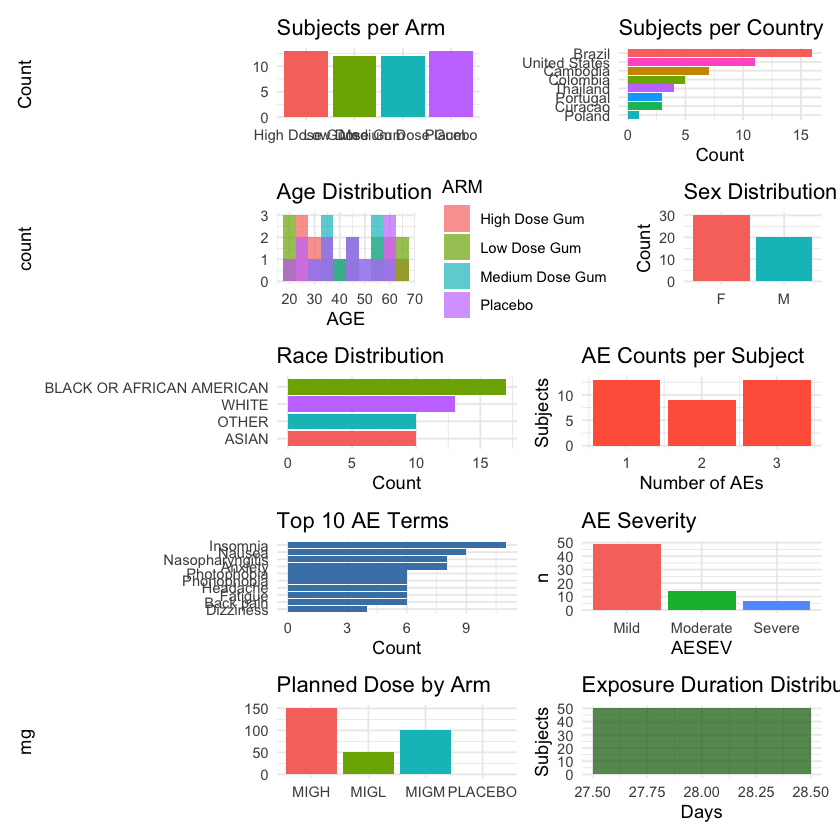

In [27]:
# --- Dashboard for MIG666 Trial -----------------------------------------------
library(ggplot2)
library(dplyr)
library(patchwork)

# 1. Subjects per ARM
p1 <- dm_df %>%
  count(ARM) %>%
  ggplot(aes(x = ARM, y = n, fill = ARM)) +
  geom_col(show.legend = FALSE) +
  labs(title="Subjects per Arm", y="Count", x="") +
  theme_minimal()

# 2. Subjects per Country
p2 <- dm_df %>%
  count(COUNTRY) %>%
  ggplot(aes(x = reorder(COUNTRY, n), y = n, fill = COUNTRY)) +
  geom_col(show.legend = FALSE) +
  coord_flip() +
  labs(title="Subjects per Country", y="Count", x="") +
  theme_minimal()

# 3. Age distribution
p3 <- ggplot(dm_df, aes(x = AGE, fill = ARM)) +
  geom_histogram(binwidth = 5, alpha=0.7, position="identity") +
  labs(title="Age Distribution") +
  theme_minimal()

# 4. Sex distribution
p4 <- dm_df %>%
  count(SEX) %>%
  ggplot(aes(x=SEX, y=n, fill=SEX)) +
  geom_col(show.legend = FALSE) +
  labs(title="Sex Distribution", y="Count", x="") +
  theme_minimal()

# 5. Race distribution
p5 <- dm_df %>%
  count(RACE) %>%
  ggplot(aes(x = reorder(RACE, n), y = n, fill = RACE)) +
  geom_col(show.legend = FALSE) +
  coord_flip() +
  labs(title="Race Distribution", y="Count", x="") +
  theme_minimal()

# 6. AE counts per subject
p6 <- ae_df %>%
  count(USUBJID) %>%
  ggplot(aes(x = n)) +
  geom_bar(fill="tomato") +
  labs(title="AE Counts per Subject", x="Number of AEs", y="Subjects") +
  theme_minimal()

# 7. AE terms frequency
p7 <- ae_df %>%
  count(AETERM) %>%
  arrange(desc(n)) %>%
  slice_head(n=10) %>%
  ggplot(aes(x = reorder(AETERM, n), y = n)) +
  geom_col(fill="steelblue") +
  coord_flip() +
  labs(title="Top 10 AE Terms", y="Count", x="") +
  theme_minimal()

# 8. AE severity distribution
p8 <- ae_df %>%
  count(AESEV) %>%
  ggplot(aes(x=AESEV, y=n, fill=AESEV)) +
  geom_col(show.legend = FALSE) +
  labs(title="AE Severity") +
  theme_minimal()

# 9. Exposure dose per arm
p9 <- ex_df %>%
  distinct(ARMCD, EXDOSE) %>%
  ggplot(aes(x=ARMCD, y=EXDOSE, fill=ARMCD)) +
  geom_col(show.legend=FALSE) +
  labs(title="Planned Dose by Arm", y="mg", x="") +
  theme_minimal()

# 10. Subject follow-up duration (EXDUR)
p10 <- ex_df %>%
  ggplot(aes(x=EXDUR)) +
  geom_histogram(binwidth=1, fill="darkgreen", alpha=0.7) +
  labs(title="Exposure Duration Distribution", x="Days", y="Subjects") +
  theme_minimal()

# --- Combine into dashboard (grid layout) -------------------------------------
dashboard <- (p1 | p2) /
             (p3 | p4) /
             (p5 | p6) /
             (p7 | p8) /
             (p9 | p10)

dashboard

In [36]:
ggsave("MIG666_dashboard1.pdf", dashboard, width = 20, height = 15)

# ***dashboard of 5 panels:***

***Age by Arm → violin + boxplot overlay***

***Sex ratio per Country → stacked % bar chart***

***AE onset timeline → density curves over days, colored by severity***

***AE severity proportions → polar pie chart***

***Exposure duration by Arm → violin + jitter***

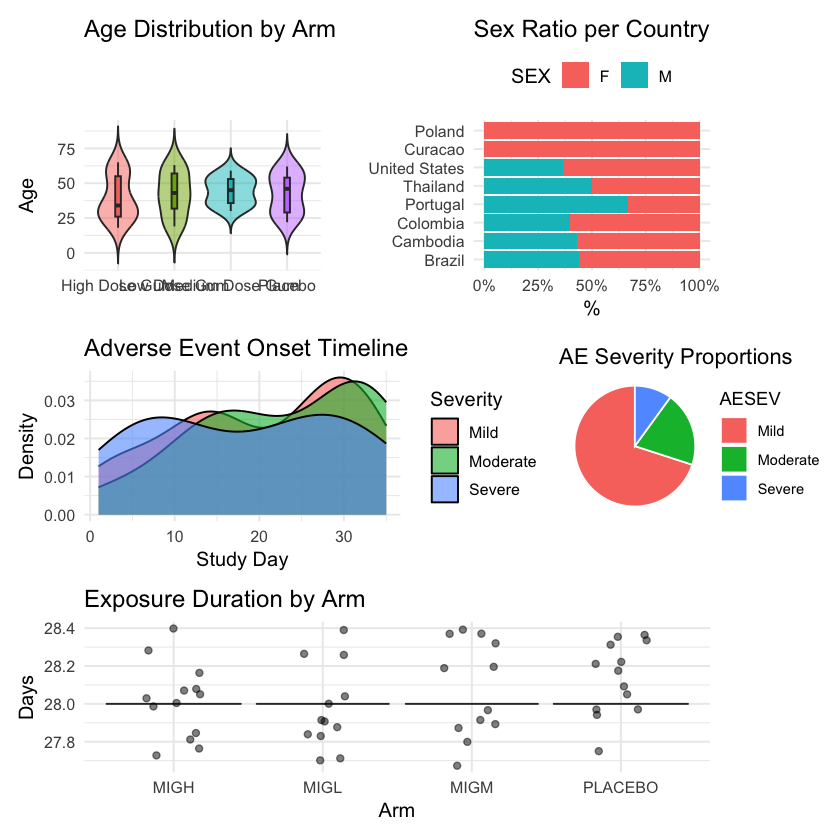

In [38]:
# --- Dashboard2 (5 plots) ------------------------------------------------
library(ggplot2)
library(dplyr)
library(patchwork)

# 1. Age distribution by arm (violin + boxplot)
f1 <- ggplot(dm_df, aes(x = ARM, y = AGE, fill = ARM)) +
  geom_violin(alpha=0.5, trim=FALSE) +
  geom_boxplot(width=0.1, outlier.shape=NA) +
  theme_minimal(base_size=12) +
  labs(title="Age Distribution by Arm", x="", y="Age") +
  theme(legend.position="none")

# 2. Sex ratio by country (stacked bar %)
f2 <- dm_df %>%
  count(COUNTRY, SEX) %>%
  group_by(COUNTRY) %>%
  mutate(pct = n/sum(n)) %>%
  ggplot(aes(x=reorder(COUNTRY, pct), y=pct, fill=SEX)) +
  geom_col() +
  coord_flip() +
  scale_y_continuous(labels=scales::percent) +
  theme_minimal(base_size=12) +
  labs(title="Sex Ratio per Country", x="", y="%") +
  theme(legend.position="top")

# 3. AE onset timeline (density of start days)
f3 <- ae_df %>%
  mutate(day = as.integer(as.Date(AESTDTC) - as.Date("2025-01-01"))) %>%
  ggplot(aes(x=day, fill=AESEV)) +
  geom_density(alpha=0.6) +
  theme_minimal(base_size=12) +
  labs(title="Adverse Event Onset Timeline", x="Study Day", y="Density", fill="Severity")

# 4. AE severity proportions (pie chart)
f4 <- ae_df %>%
  count(AESEV) %>%
  ggplot(aes(x="", y=n, fill=AESEV)) +
  geom_col(width=1, color="white") +
  coord_polar(theta="y") +
  theme_void() +
  labs(title="AE Severity Proportions") +
  theme(legend.position="right")

# 5. Exposure duration violin by arm
f5 <- ex_df %>%
  ggplot(aes(x=ARMCD, y=EXDUR, fill=ARMCD)) +
  geom_violin(alpha=0.5) +
  geom_jitter(width=0.2, alpha=0.5) +
  theme_minimal(base_size=12) +
  labs(title="Exposure Duration by Arm", x="Arm", y="Days") +
  theme(legend.position="none")

# --- Arrange into a 5-plot dashboard ------------------------------------------
dashboard2 <- (f1 | f2) / (f3 | f4) / f5
dashboard2

In [40]:
ggsave("MIG666_dashboard2.pdf", dashboard2, width = 20, height = 15)